# Implementing LSTM

- Using Fake news classifier
- based on previous codes, it has been modified for parameters

# 1)- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2- Loading and preparing data

- Dataset: https://www.kaggle.com/c/fake-news/data#

In [5]:
df=pd.read_csv('train.csv')
df.shape

(20800, 5)

In [6]:
df.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [7]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
###Drop Nan Values
df=df.dropna()
df.shape

(18285, 5)

In [9]:
df.to_csv('ready_data.csv', index=0)

In [10]:
df=pd.read_csv('ready_data.csv')
df.shape

(18285, 5)

In [11]:
## Get the Independent Features

X=df[['title']]

In [12]:
## Get the Dependent features
y=df['label']

In [13]:
print(X.shape)
print(y.shape)

(18285, 1)
(18285,)


In [14]:
X.head()

,title
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired
3,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...


### checking target variable

In [15]:
df.label.value_counts()

0    10361
1     7924
Name: label, dtype: int64

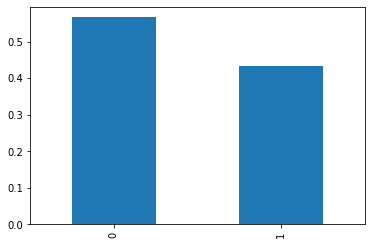

In [16]:
df.label.value_counts(normalize=True).plot(kind='bar')

In [17]:
df.label.value_counts(normalize=True)

0    0.566639
1    0.433361
Name: label, dtype: float64

Classes of fake and non-fake news are pretty much balanced. Still, we shall use class weight to avoid any biased outcome

### 2.1.Corpus building

In [18]:
titles=X.copy()

In [19]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(titles)):
    review = re.sub('[^a-zA-Z]', ' ', titles['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [20]:
df['cleaned']= corpus

In [21]:
df.cleaned[0]

'hous dem aid even see comey letter jason chaffetz tweet'

In [22]:
df.title[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

### 2.2.train-test Split

In [23]:
y=df['label']
X=df.cleaned

In [24]:
print(X.shape)
print(y.shape)

(18285,)
(18285,)


In [25]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(y, random_state=42)

### 2.3. Encoding target variable

In [26]:
print(y_train.shape)
print(y_test.shape)

(13713,)
(4572,)


In [27]:
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [28]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(13713, 2)
(4572, 2)


### 2.4.Working with X variable

- **Convert words to matrix** <br>
We need to convert words into matrices. One way is shown through sklearn. Other way is given. We can always match the two

- Vectorize text, by turning each text into either a sequence of integers or into a vector.We use Keras Tokenizer.
- Limit the data set to the top 5,000 words i.e vocabulary size.
- Set the max number of words in each sentence at 20.

##### 2.4.1-I started by fitting a tokenizer on my document as in here:

In [29]:
#checking average sentence length
import numpy as np

average_length = np.mean([len(x) for x in X])
print("Average sequence length: ", average_length)

Average sequence length:  52.68170631665299


In [30]:
# The maximum number of words to be used. (most frequent)
voc_size = 5000 # it is size of our vocabulary
# Max number of words in each sentence.
sent_length = 50
# We can play with this. It is dimension of embedding layer.
embedding_vector_features = 40 

tokenizer = Tokenizer(num_words=voc_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)

In [31]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13931 unique tokens.


##### 2.4.2- I wanted to check if my data is fitted correctly so I converted into sequence

In [32]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X.values)

In [33]:
tokens_feature=pd.DataFrame(X_token)
tokens_feature.head(2)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,31.0,221.0,243.0,50.0,142.0,102.0,509.0,1775.0,3009.0,420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,829.0,6.0,7.0,110.0,150.0,1090.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
tokens_feature.shape

(18285, 45)

##### check how it is seen in original data

In [35]:
df.title[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [36]:
df.title[2]

'Why the Truth Might Get You Fired'

### 2.4.3.pad_sequence:To keep all vectors of same length, I will use pad_sequence

In [37]:
X_pd_sq = pad_sequences(X_token,maxlen=sent_length)
X_pd_sq.shape

(18285, 50)

In [38]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,31,221,243,50,142,102,509,1775,3009,420
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,829,6,7,110,150,1090,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,335,856,33,83
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,567,34,1157,20,887,1682
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1187,150,597,3305,253,150,1459,135


### 2.5. Train test split for X variable

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd_sq,y,random_state=42)

In [40]:
X_train.shape, X_test.shape

((13713, 50), (4572, 50))

### 2.6. Double check for target data label

original vs one-hot coded

In [41]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(13713, 2)
(4572, 2)


In [42]:
y_train[:5]

13867    0
4127     0
5265     0
8360     0
15699    1
Name: label, dtype: int64

In [43]:
y_train_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [44]:
y_test[:5]

10363    1
6134     0
13100    0
12643    0
14556    1
Name: label, dtype: int64

In [45]:
y_test_ohe[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [46]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

[0, 1]

In [47]:
len(unique_y_labels)

2

In [48]:
X_pd_sq.shape[1]

50

# 3-Build LSTM model
The first layer is the embedded layer that uses 40 length vectors to represent each word.<br>
SpatialDropout1D performs variational dropout in NLP models.<br>
The next layer is the LSTM layer with 100 memory units.<br>
The output layer must create 1 output values, one for fake-zero for non-fake class.<br>
Activation function is softmax for binary classification.<br>
Because it is a binary classification problem, binary_crossentropy is used as the loss function

In [49]:
# The maximum number of words to be used. (most frequent/top words)
voc_size = 5000 # this is same as size of our vocabulary
# Max number of words in each sentence.
sent_length=20
# This is fixed.
embedding_vector_features=40 # dimension of embedding layer
epochs=10
batch_size=32
# for our padding seq
input_length=X_pd_sq.shape[1] # same as sent_length
uniq_y_label=len(unique_y_labels) # this will be dimension of our output layer i.e 2

### 3.1. Defining basic model architecture

In [50]:
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=X_pd_sq.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(uniq_y_label, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 40)            200000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 256,602
Trainable params: 256,602
Non-trainable params: 0
_________________________________________________________________


##### Summary params calculation
https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

There are three steps:

- For embedding layer: Dim of embedded layer(40) * vocab_size(5000)

- For LSTM Layer: Now formula is #of params=g*[h(h+i)+biase]

where g=lstm layer length i.e 1. For FFNS, RNN has 1 , LSTM has 4 and GRU has 3 layers<br>
h=hidden layer size (number of neurons in hidden layer) i.e 100<br>
i=Input size/dimension i.e embedding_vector_features that is coming as an input on lstm layer in step2 (40 is value)<br>
biase= 100 of neurons for outpt of lstm layer<br>

4*[100(100+40)+100]

- For Dense (Output): lstm layer acting as input(100) * neurons in output layer(2) + biase(2 as there is only one neuron in output layer)

### 3.2.Model Training

In [52]:
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [55]:
history=model.fit(X_train,y_train_ohe,validation_data=(X_test,y_test_ohe),
                          class_weight=class_weights,epochs=epochs,batch_size=batch_size,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, 
                                                   min_delta=0.0001)])

Train on 13713 samples, validate on 4572 samples
Epoch 1/10
13713/13713 [==============================] - 12s 876us/step - loss: 0.2507 - accuracy: 0.8870 - val_loss: 0.1984 - val_accuracy: 0.9178
Epoch 2/10
13713/13713 [==============================] - 12s 840us/step - loss: 0.1207 - accuracy: 0.9539 - val_loss: 0.1921 - val_accuracy: 0.9213
Epoch 3/10
13713/13713 [==============================] - 12s 882us/step - loss: 0.0831 - accuracy: 0.9708 - val_loss: 0.2181 - val_accuracy: 0.9186
Epoch 4/10
13713/13713 [==============================] - 12s 877us/step - loss: 0.0607 - accuracy: 0.9794 - val_loss: 0.2645 - val_accuracy: 0.9140
Epoch 5/10
13713/13713 [==============================] - 12s 851us/step - loss: 0.0424 - accuracy: 0.9856 - val_loss: 0.2997 - val_accuracy: 0.9167


# 4- Model Evaluation

### 4.1.Accuracy and loss scores

In [56]:
accr = model.evaluate(X_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4572/4572 [==============================] - 1s 264us/step
Test set
  Loss: 0.300
  Accuracy: 0.917


### 4.2.probabilities ditribution

In [57]:
# predict probabilities for test set
y_pred = model.predict(X_test)
y_pred[:5]

array([[1.2852210e-03, 9.9871480e-01],
       [9.9999225e-01, 7.7792429e-06],
       [9.9676538e-01, 3.2346332e-03],
       [9.8869205e-01, 1.1307931e-02],
       [4.3335461e-04, 9.9956661e-01]], dtype=float32)

**This is probabilities of our output. We need to convert to crisp classes.**

In [58]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes[:5]

array([1, 0, 0, 0, 1], dtype=int64)

**compare with original**

In [59]:
y_test_ohe[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [60]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [61]:
y_test_class[:5]

array([1, 0, 0, 0, 1], dtype=int64)

In [62]:
y_pred_class[:5]

array([1, 0, 0, 0, 1], dtype=int64)

So all five example we chose were predicted correctly

### 4.3.Classification Report

In [63]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2600
           1       0.89      0.92      0.90      1972

    accuracy                           0.92      4572
   macro avg       0.91      0.92      0.92      4572
weighted avg       0.92      0.92      0.92      4572



### 4.4.Confusion Matrix

In [64]:
print(confusion_matrix(y_test_class,y_pred_class))

[[2378  222]
 [ 159 1813]]


<Figure size 864x864 with 0 Axes>

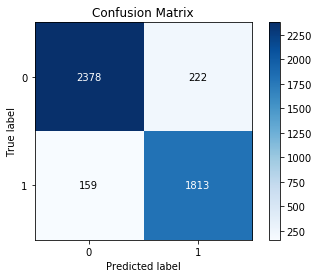

In [65]:
import scikitplot as skplt
plt.figure(figsize=(12,12))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class)
plt.show()

### 4.5.Plotting Accuracy and loss scores

In [66]:
# for training set
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.9954
Training Loss: 0.0181


In [67]:
# For test set
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.9167
Testing Loss:  0.2997


In [68]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

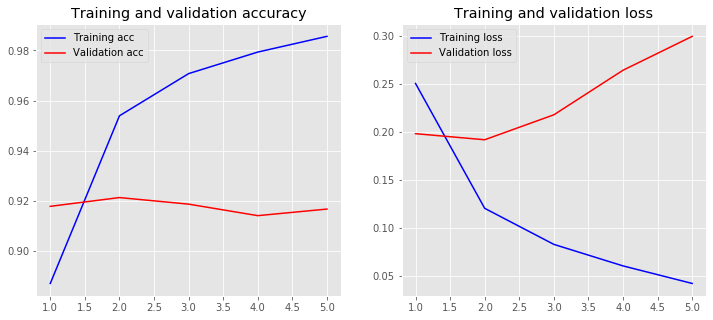

In [69]:
plot_history(history)

### 4.6.weights at each step of neural network at each time step

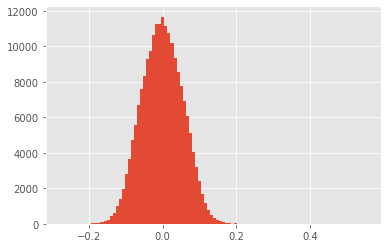

In [70]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

In [71]:
model.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(5000, 40) dtype=float32, numpy=
 array([[ 0.02685678,  0.0264054 , -0.00854015, ...,  0.06233399,
         -0.03318567, -0.00651845],
        [ 0.02767581,  0.02757649, -0.05430548, ...,  0.02912684,
         -0.0400617 , -0.01366112],
        [ 0.0066477 , -0.10161695,  0.03925545, ..., -0.04543609,
          0.08596822, -0.05501283],
        ...,
        [-0.0114033 , -0.00593205, -0.0274486 , ...,  0.03189726,
         -0.01599741, -0.05362242],
        [ 0.00472634,  0.06259213,  0.0001425 , ...,  0.07499982,
         -0.01840282,  0.05368747],
        [-0.01221752, -0.01014705, -0.03743995, ..., -0.01540675,
          0.01227286,  0.03622774]], dtype=float32)>,
 <tf.Variable 'lstm_1/kernel:0' shape=(40, 400) dtype=float32, numpy=
 array([[-0.07727136,  0.165171  ,  0.14297888, ..., -0.1243658 ,
         -0.05707882,  0.07335225],
        [-0.11191288,  0.12775658,  0.07915514, ..., -0.3135947 ,
         -0.1030724 , -0.10044271],
   